* WALMART HACKATHON ROUND 2

In [ ]:
import os
import pandas as pd
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the path to the directory containing the data files
data_dir = "/kaggle/input/data-q4-2023/"

# Define the path to store the processed data
processed_data_dir = "/kaggle/working/processed_data/"

# Create the directory if it does not exist
os.makedirs(processed_data_dir, exist_ok=True)

# Define chunk size for reading data
chunk_size = 10000

# Process each file individually and store the processed data
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(data_dir, file_name)
        df_chunks = pd.read_csv(file_path, chunksize=chunk_size)
        for i, chunk in enumerate(df_chunks):
            # Upsample the failure class if there are failures
            valid = chunk[chunk['failure'] == 0]
            failed = chunk[chunk['failure'] == 1]
            if len(valid) > 0 and len(failed) > 0:
                failed_up = resample(failed, replace=True, n_samples=len(valid), random_state=27)
                chunk_processed = pd.concat([valid, failed_up])

                # Drop irrelevant columns and handle missing values
                features = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure', 'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']
                misc_feat = [fname for fname in chunk_processed if fname not in features]
                chunk_processed.drop(misc_feat, inplace=True, axis=1)
                chunk_processed['smart_187_raw'] = chunk_processed['smart_187_raw'].fillna(0)
                chunk_processed['smart_5_raw'] = chunk_processed['smart_5_raw'].fillna(0)
                chunk_processed['smart_188_raw'] = chunk_processed['smart_188_raw'].fillna(0)
                chunk_processed['smart_197_raw'] = chunk_processed['smart_197_raw'].fillna(0)
                chunk_processed['smart_198_raw'] = chunk_processed['smart_198_raw'].fillna(0)
                chunk_processed = chunk_processed.drop('capacity_bytes', axis=1)
                chunk_processed = chunk_processed.drop('model', axis=1)
                chunk_processed = chunk_processed.drop('serial_number', axis=1)
                chunk_processed = chunk_processed.drop('date', axis=1)

                # Save the processed chunk to a file
                processed_file_path = os.path.join(processed_data_dir, f"{file_name.split('.')[0]}_{i}.csv")
                chunk_processed.to_csv(processed_file_path, index=False)

# Load all processed files and concatenate them into a single DataFrame
dfs = []
for processed_file_name in os.listdir(processed_data_dir):
    processed_file_path = os.path.join(processed_data_dir, processed_file_name)
    df = pd.read_csv(processed_file_path)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Split the data into training and testing sets
X = df_all.drop('failure', axis=1)


Y = df_all['failure']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

# Make predictions and evaluate the model
Y_pred = rfc.predict(X_test)

acc = accuracy_score(Y_test, Y_pred)
prec = precision_score(Y_test, Y_pred)
rec = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
mcc = matthews_corrcoef(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print("Model used is: Random Forest classifier")
print("The accuracy is {}".format(acc))
print("The precision is {}".format(prec))
print("The recall is {}".format(rec))
print("The F1-Score is {}".format(f1))
print("The Matthews correlation coefficient is {}".format(mcc))
print("Confusion Matrix:")
print(conf_matrix)


Model used is: Random Forest classifier
The accuracy is 0.8645274245761978
The precision is 0.9724285051075976
The recall is 0.750438127179142
The F1-Score is 0.8471316496738619
The Matthews correlation coefficient is 0.7488653018393554
Confusion Matrix:
[[1435794   31239]
 [ 366402 1101779]]


In [ ]:
import joblib

# Save the model to a file
joblib.dump(rfc, 'random_forest_model_for_hard_disk.pkl')

# Later, you can load the model using:
# loaded_model = joblib.load('random_forest_model.pkl')


['random_forest_model_for_hard_disk.pkl']

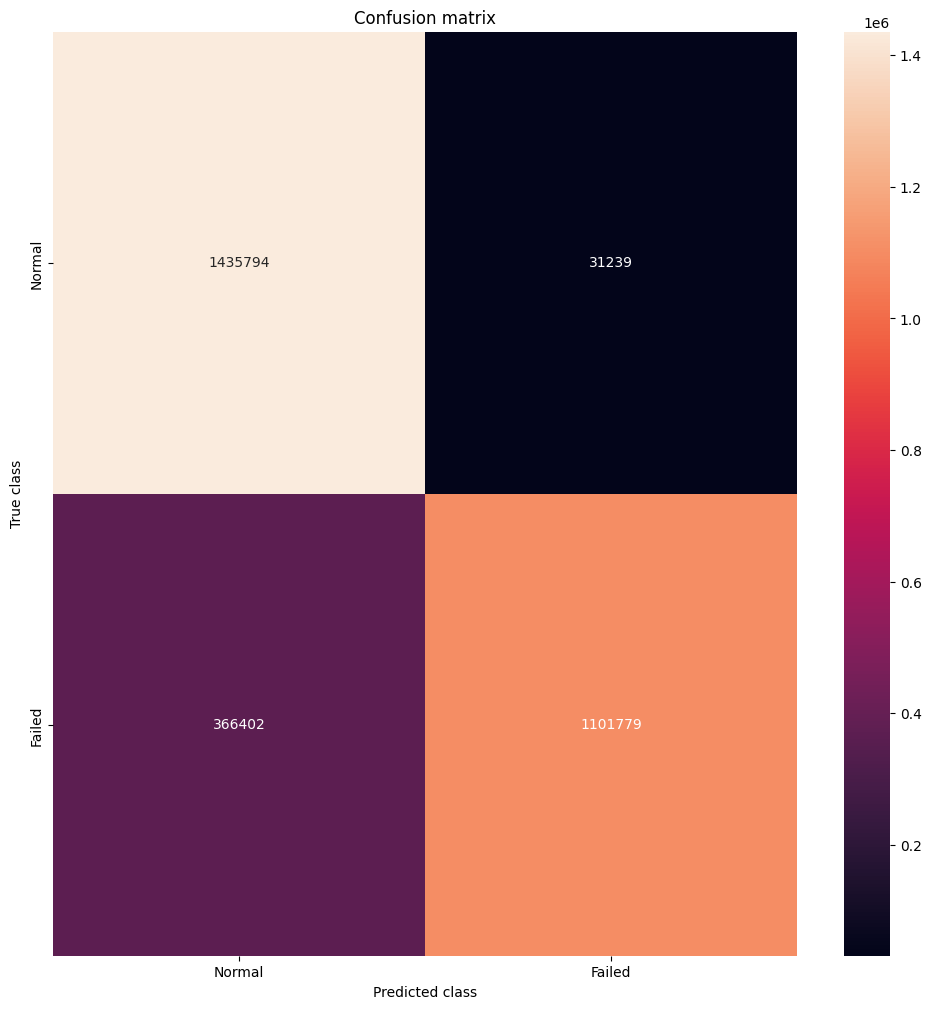

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

LABELS = ['Normal', 'Failed']
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [ ]:
import joblib

# Load the model from the file
loaded_model = joblib.load('/kaggle/working/random_forest_model_for_hard_disk.pkl')

# Now, you can use this loaded_model for predictions
y_pred_loaded_model = loaded_model.predict(X_test)
print(y_pred_loaded_model)

[0 1 1 ... 0 0 1]


In [ ]:
print(X_test.head)

<bound method NDFrame.head of           smart_5_raw  smart_187_raw  smart_188_raw  smart_197_raw  \
6939181           0.0            0.0            0.0            0.0   
13275557          0.0           45.0       262151.0         1760.0   
1632646         240.0            0.0            0.0            7.0   
11213038         15.0            0.0            0.0          816.0   
9144642          32.0           41.0       589833.0          648.0   
...               ...            ...            ...            ...   
799639            2.0            0.0            0.0            5.0   
4467823          24.0            0.0            0.0            0.0   
2073804           0.0            0.0            0.0            0.0   
10387287          0.0            0.0            0.0            0.0   
9578901        9432.0           25.0            0.0            0.0   

          smart_198_raw  
6939181             0.0  
13275557         1760.0  
1632646             0.0  
11213038            0.0  

In [ ]:
import joblib
import pickle

# Load the trained model using joblib
loaded_model = joblib.load('random_forest_model_for_hard_disk.pkl')

# Dump the model using pickle
with open('random_forest_model_for_hard_disk.pkl', 'wb') as f:
    pickle.dump(loaded_model, f)

# Load the model using pickle to ensure compatibility
with open('random_forest_model_for_hard_disk.pkl', 'rb') as f:
    loaded_model_pickle = pickle.load(f)

# Now, you can use loaded_model_pickle for predictions
y_pred_loaded_model = loaded_model_pickle.predict(X_test)
print(y_pred_loaded_model)


[0 1 1 ... 0 0 1]


In [ ]:
with open('random_forest_model_for_hard_disk.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Define a function to take user inputs and make predictions
def predict_hard_disk_failure():
    # Ask the user for input features
    smart_5_raw = float(input("Enter the value of smart_5_raw: "))
    smart_187_raw = float(input("Enter the value of smart_187_raw: "))
    smart_188_raw = float(input("Enter the value of smart_188_raw: "))
    smart_197_raw = float(input("Enter the value of smart_197_raw: "))
    smart_198_raw = float(input("Enter the value of smart_198_raw: "))

    # Create a DataFrame with the user inputs
    input_data = {
        'smart_5_raw': [smart_5_raw],
        'smart_187_raw': [smart_187_raw],
        'smart_188_raw': [smart_188_raw],
        'smart_197_raw': [smart_197_raw],
        'smart_198_raw': [smart_198_raw]
    }
    input_df = pd.DataFrame(input_data)

    # Make a prediction using the loaded model
    prediction = loaded_model.predict(input_df)[0]

    # Display the prediction
    if prediction == 0:
        print("The hard disk is predicted to be normal.")
    else:
        print("The hard disk is predicted to fail.")

# Call the function to make predictions based on user inputs
predict_hard_disk_failure()

Enter the value of smart_5_raw:  0
Enter the value of smart_187_raw:  0
Enter the value of smart_188_raw:  0
Enter the value of smart_197_raw:  0
Enter the value of smart_198_raw:  0


The hard disk is predicted to be normal.
